In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, accuracy_score
import os
import random
import cv2
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns

In [ ]:
base_dir = '/content/drive/MyDrive/archive (4)/BoneFractureYolo8'
output_dir = '/content/drive/MyDrive/archive (4)'

class_directories = ['elbow_positive', 'fingers_positive', 'forearm_fracture', 'humerus_fracture',
                     'humerus', 'shoulder_fracture', 'wrist_positive']
splits = ['train', 'valid', 'test']

In [ ]:
for split in splits:
    for class_dir in class_directories:
        os.makedirs(os.path.join(output_dir, split, class_dir), exist_ok=True)

In [ ]:
def extract_class_labels(label_content):
    class_ids = set()
    lines = label_content.strip().split('\n')

    for line in lines:
        if line.strip():
            parts = line.split()
            if len(parts) > 0:
                try:
                    class_id = int(parts[0])
                    class_ids.add(class_id)
                except ValueError:
                    print(f"Skipping invalid line: {line}")
    return class_ids

In [ ]:
def extract_class_labels_from_file(file_path):
    with open(file_path, 'r') as file:
        label_content = file.read()
    return extract_class_labels(label_content)

In [ ]:
def move_image_to_class_folder(image_path, class_ids, split):
    for class_id in class_ids:
        class_folder = class_directories[class_id]
        output_path = os.path.join(output_dir, split, class_folder)
        if os.path.exists(image_path):
            shutil.copy(image_path, output_path)
            print(f"Moved {image_path} to {output_path}")
        else:
            print(f"Image file {image_path} not found")

In [ ]:
for split in splits:
    labels_dir = os.path.join(base_dir, split, 'labels')
    images_dir = os.path.join(base_dir, split, 'images')

    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_file_path = os.path.join(labels_dir, label_file)
            image_file = label_file.replace('.txt', '.jpg')

            image_path = os.path.join(images_dir, image_file)

            class_ids = extract_class_labels_from_file(label_file_path)

            if class_ids:
                move_image_to_class_folder(image_path, class_ids, split)

Moved /content/drive/MyDrive/archive (4)/BoneFractureYolo8/train/images/image1_7651_png.rf.6a0843ea347cdc8b84009b4e1adf0bcf.jpg to /content/drive/MyDrive/archive (4)/train/shoulder_fracture
Moved /content/drive/MyDrive/archive (4)/BoneFractureYolo8/train/images/image1_66_png.rf.b9e2e20bd8ee9e74637cb1db0f5cb296.jpg to /content/drive/MyDrive/archive (4)/train/humerus
Image file /content/drive/MyDrive/archive (4)/BoneFractureYolo8/train/images/image2_1695_png.rf.04714a02faf669120b8d672ca7f20865.jpg not found
Image file /content/drive/MyDrive/archive (4)/BoneFractureYolo8/train/images/image2_441_png.rf.7a4e4d386e8798ff2b9251554c2b6a0f.jpg not found
Moved /content/drive/MyDrive/archive (4)/BoneFractureYolo8/train/images/image2_361_png.rf.aa0d1c6eba35fad46d6f7fdebee7b24b.jpg to /content/drive/MyDrive/archive (4)/train/shoulder_fracture
Image file /content/drive/MyDrive/archive (4)/BoneFractureYolo8/train/images/image1_959_png.rf.5517a622772d8d63a3801722466a83fe.jpg not found
Moved /content/d

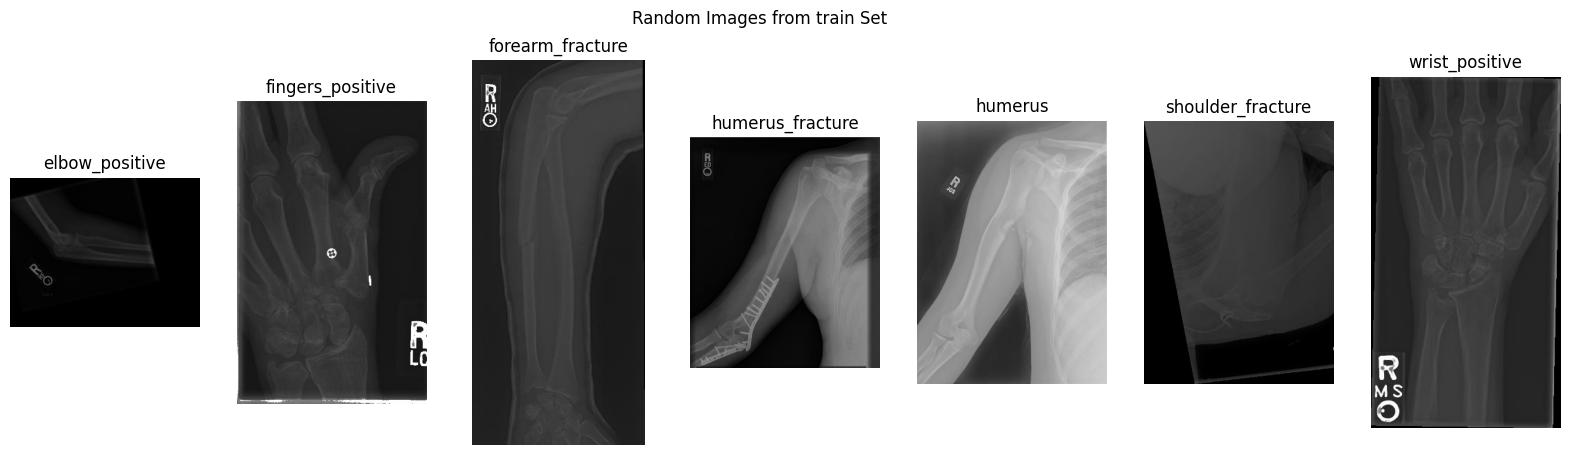

In [ ]:
def display_random_images(split='train'):
    fig, axes = plt.subplots(1, len(class_directories), figsize=(20, 5))
    fig.suptitle(f'Random Images from {split} Set')

    for i, class_dir in enumerate(class_directories):
        class_path = os.path.join(output_dir, split, class_dir)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]

        if len(image_files) > 0:
            random_image = random.choice(image_files)
            image_path = os.path.join(class_path, random_image)
            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(class_dir)
        else:
           print(f"No images found in class directory: {class_dir}")

    plt.show()

display_random_images(split='train')

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
dir_path = '/content/drive/MyDrive/archive (4)/test/humerus_fracture'

if os.path.exists(dir_path) and not os.listdir(dir_path):
    os.rmdir(dir_path)
    print(f"Directory {dir_path} deleted.")
else:
    print(f"Directory {dir_path} is not empty or does not exist.")

Directory /content/drive/MyDrive/archive (4)/test/humerus_fracture deleted.


In [ ]:
dir_path = '/content/drive/MyDrive/archive (4)/valid/humerus_fracture'

if os.path.exists(dir_path) and not os.listdir(dir_path):
    os.rmdir(dir_path)
    print(f"Directory {dir_path} deleted.")
else:
    print(f"Directory {dir_path} is not empty or does not exist.")

Directory /content/drive/MyDrive/archive (4)/valid/humerus_fracture deleted.


##Load the Dataset

In [ ]:
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/archive (4)/train', transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder('/content/drive/MyDrive/archive (4)/valid', transform=data_transforms['valid'])
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/archive (4)/test', transform=data_transforms['test'])

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
num_classes = len(train_dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


In [ ]:
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        val_acc = val_running_corrects.double() / len(valid_loader.dataset)
        print(f'Validation Acc: {val_acc:.4f}')

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    print(f'Best Validation Accuracy: {best_acc:.4f}')

In [ ]:
train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=12)

Epoch 1/12
Train Loss: 1.1957 Acc: 0.5793
Validation Acc: 0.4624
Epoch 2/12
Train Loss: 0.6451 Acc: 0.7551
Validation Acc: 0.4855
Epoch 3/12
Train Loss: 0.4935 Acc: 0.8333
Validation Acc: 0.6127
Epoch 4/12
Train Loss: 0.4997 Acc: 0.8028
Validation Acc: 0.6012
Epoch 5/12
Train Loss: 0.3205 Acc: 0.8770
Validation Acc: 0.6069
Epoch 6/12
Train Loss: 0.3163 Acc: 0.8963
Validation Acc: 0.5549
Epoch 7/12
Train Loss: 0.2569 Acc: 0.9177
Validation Acc: 0.6358
Epoch 8/12
Train Loss: 0.1636 Acc: 0.9472
Validation Acc: 0.6647
Epoch 9/12
Train Loss: 0.0857 Acc: 0.9715
Validation Acc: 0.6994
Epoch 10/12
Train Loss: 0.0841 Acc: 0.9756
Validation Acc: 0.7052
Epoch 11/12
Train Loss: 0.0583 Acc: 0.9868
Validation Acc: 0.6994
Epoch 12/12
Train Loss: 0.0620 Acc: 0.9837
Validation Acc: 0.6936
Best Validation Accuracy: 0.7052


In [ ]:
import torch

torch.save(model, "/content/drive/MyDrive/resnet_model.pth")

<ipython-input-23-34e665ddb571>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 0.6627


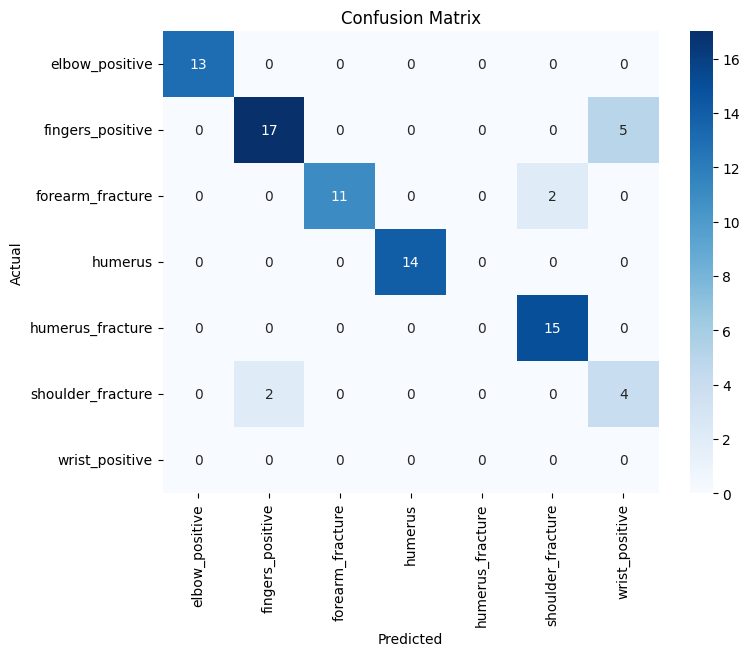

In [ ]:
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Get predictions
all_labels, all_preds = evaluate_model(model, test_loader)
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {acc:.4f}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


<ipython-input-26-9cedde2766f7>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
/usr/local/lib/python3.10/dist-packages

Test Accuracy: 0.6627

Classification Report:
                    precision    recall  f1-score   support

   elbow_positive       1.00      1.00      1.00        13
 fingers_positive       0.89      0.77      0.83        22
 forearm_fracture       1.00      0.85      0.92        13
          humerus       1.00      1.00      1.00        14
 humerus_fracture       0.00      0.00      0.00        15
shoulder_fracture       0.00      0.00      0.00         6
   wrist_positive       0.00      0.00      0.00         0

         accuracy                           0.66        83
        macro avg       0.56      0.52      0.54        83
     weighted avg       0.72      0.66      0.69        83



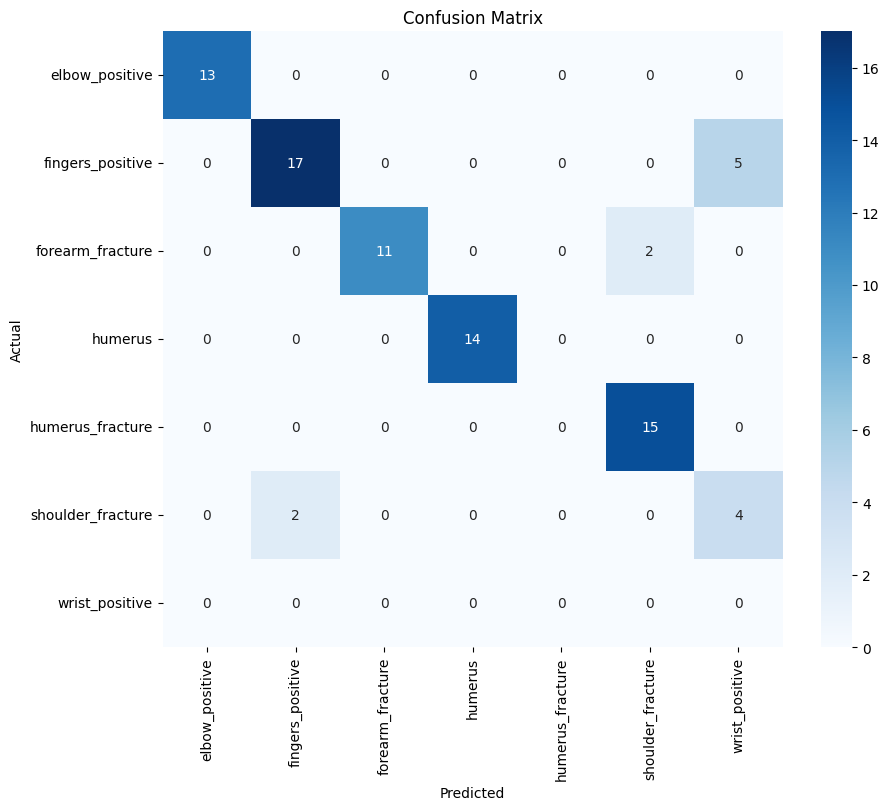

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, device):
    """
    Evaluate the performance of a model on a test dataset.

    Args:
        model: The PyTorch model to be evaluated.
        test_loader: DataLoader for the test dataset.
        device: Device ('cpu' or 'cuda') to run the evaluation on.

    Returns:
        all_labels: True labels from the test dataset.
        all_preds: Predicted labels from the model.
    """
    try:
        # Load model weights
        model.load_state_dict(torch.load('best_model.pth'))
        model.eval()
        model.to(device)

        all_preds = []
        all_labels = []

        # Disable gradient calculations for evaluation
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)  # Get predictions
                all_preds.extend(preds.cpu().numpy())  # Move to CPU
                all_labels.extend(labels.cpu().numpy())  # Move to CPU

        return all_labels, all_preds

    except Exception as e:
        print(f"Error during evaluation: {e}")
        return [], []

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """
    Plot a confusion matrix using Seaborn.

    Args:
        cm: Confusion matrix (2D array).
        class_names: List of class names.
        title: Title for the plot.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

# Evaluate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Automatically choose the device
all_labels, all_preds = evaluate_model(model, test_loader, device)

if all_labels and all_preds:
    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)

    # Print metrics
    print(f"Test Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", report)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, train_dataset.classes)
else:
    print("Evaluation failed due to errors.")